# Temperature Vs. Probability of Failure

If the job of the data scientist is to create a model, the job of the data engineer is to put a model into production. Here we illustrate both steps using the Python API.

First, we create a sample data set. The 'x' axis represents the average temperature of an engine over the past two hours, and the y axis reprents the probability that the engine will fail in the next 30 minutes.

<IPython.core.display.Javascript object>


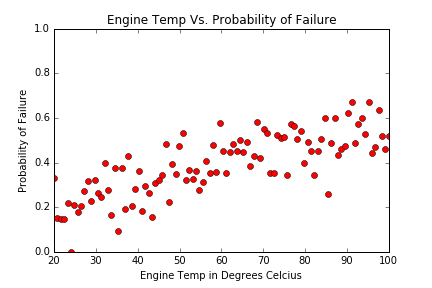

(<matplotlib.figure.Figure at 0x7f81dd255898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f81d63207b8>)

In [1]:
%matplotlib inline
%matplotlib notebook

import numpy as np, math
import matplotlib.pyplot as plt
from pybrain.datasets import SupervisedDataSet
from pybrain.structure import SigmoidLayer, LinearLayer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer

# Create sample dataset
xvalues = np.linspace(20,100, 100)
yvalues = np.array([((np.cos((x-50)/100)*100 + np.sin(x/100)*100 + np.random.normal(0, 13, 1)[0])/150.0) for x in xvalues])
yvalues = [y - np.amin(yvalues) for y in yvalues]

# Plot dataset
def create_plot(xvalues, yvalues, title=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    fig, ax = plt.subplots()
    plt.title("Engine Temp Vs. Probability of Failure")
    plt.ylabel("Probability of Failure")
    plt.xlabel("Engine Temp in Degrees Celcius")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xvalues,
            yvalues, "ro", linewidth = 2, color = 'red', label = 'target')
    return fig,ax

create_plot(xvalues, yvalues, title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))


# Build a Model to Fit The Data

We want to create a model which takes a temperature, and provides an approximate probability of failure. Here, we use a library called PyBrain which trains a feed forward neural net (FFN) to predict failure probability. If you don't have PyBrain installed, install it using this command (the default pip repo won't work):

    pip install git+https://github.com/pybrain/pybrain.git

When you run this cell, you can see the model improving itself iteratively. The blue line is the model's fit.

<IPython.core.display.Javascript object>


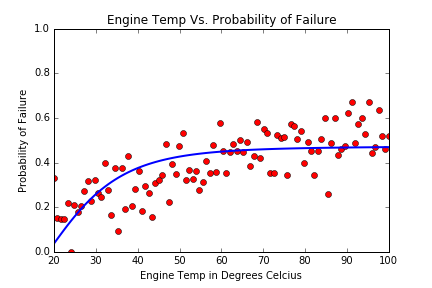

In [2]:
# The neural net to be trained
net = buildNetwork(1,100,100,100,1, bias = True, hiddenclass = SigmoidLayer, outclass = LinearLayer)

# Construct a data set of the training data
ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x,), (y,))

# The training harness. Used to train the model.
trainer = BackpropTrainer(net, ds, learningrate = 0.0001, momentum=0, verbose = False, batchlearning=False)

# Train the model. Display the model in the plot on each iteration.
fig, ax = create_plot(xvalues, yvalues, title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))

ax.plot(xvalues, [net.activate([x]) for x in xvalues], linewidth = 2, color = 'blue', label = 'NN output')

for i in range(50):
    trainer.train()
    new_yvalues = [net.activate([x]) for x in xvalues]
    ax.lines[1].set_ydata(new_yvalues)
    fig.canvas.draw()   

# Using the Model in a Realtime Streaming Application
In the above cell, we trained a model to predict failure given a temperature reading. This model is represented as a Python object `net`. Using the streamsx.topology Python API, we can insert that model into a realtime streaming application by creating classes which can create or manipulate streaming data.

The following two classes represent such creation and manipulation of data. The `periodicSource` class takes an array, and submits it's elements individually onto a stream one at a time. We can use this class to simulate sample temperature readings.

The `neural_net_model` class simply takes a data item, feeds it as input to the neural net, and returns the output onto a stream.

In [3]:
# The source of our data. Every 0.1 seconds, a number between 20-100 will be inserted into the stream
# INPUT: None
# OUTPUT: A float with range [20,100]
class periodicSource(object):
    def __call__(self):
        while True:
            time.sleep(0.1)
            yield random.uniform(20,100)

# A class which runs the neural net on data it is passed.
# INPUT: the input to the neural net, in this case a floating point number
# OUTPUT: an array containing the output of the neural net, as well as the input to the neural net.
class neural_net_model(object):
    def __init__(self, net):
        self.net = net
    def __call__(self, num):
        return [num, self.net.activate([num])[0]]

# Defining and Submitting the Streaming Application

In the next cell we create instances of the classes used to create and process data. Each tuple produced by `periodicSource` class represends a temperature reading which will be passed into and processed by the `neural_net_model` class, which produces the probability reading. Since we run this application with the `ANALYTICS_SERVICE` context, it is run in a Bluemix Streaming Analytics service.

In [4]:
from streamsx.topology import topology, context
import random
import time

# Define operator
periodic_src = periodicSource()
nnm = neural_net_model(net)

# Build Graph
top = topology.Topology("myTop")

stream_ = top.source(periodic_src)
stream_.publish("asdf")

view = stream_.transform(nnm).view()

# Submit
cnf = {context.ConfigParams.VCAP_SERVICES : "/tmp/vcap.json", 
       context.ConfigParams.SERVICE_NAME : "Streaming Analytics-be",
       context.ConfigParams.FORCE_REMOTE_BUILD : True
      }

job = context.submit(context.ContextTypes.ANALYTICS_SERVICE, top, config=cnf)

2017-03-01 07:48:44,356 - streamsx.topology.py_submit - INFO - Generating SPL and submitting application.
INFO:streamsx.topology.py_submit:Generating SPL and submitting application.


Mar 01, 2017 7:48:47 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics-be): Checking status
Mar 01, 2017 7:48:50 AM com.ibm.streamsx.topology.internal.streaminganalytics.RestUtils checkInstanceStatus
INFO: Streaming Analytics service (Streaming Analytics-be): instance status response:{"state":"STARTED","plan":"Standard","enabled":true,"status":"running"}
Mar 01, 2017 7:48:50 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics-be): submitting build myTop_AC062573D1FD96EF
Mar 01, 2017 7:49:47 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrapper remoteBuildAndSubmit
INFO: Streaming Analytics service (Streaming Analytics-be): submitting job request.
Mar 01, 2017 7:49:53 AM com.ibm.streamsx.topology.internal.context.remote.BuildServiceRemoteRESTWrap

# Graphing the Data
The output of the model can be visualized in jupyter by calling the view's `start_data_fetch` method to place the data onto a queue such that it can be retrieved and graphed my matplotlib.

<IPython.core.display.Javascript object>


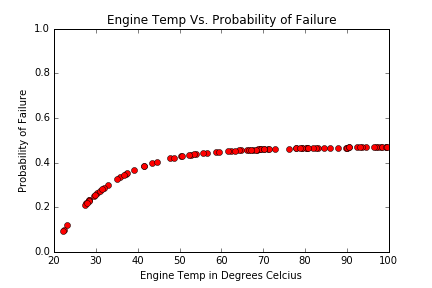

In [6]:
fig, ax = create_plot([], [], title="Engine Temp Vs. Probability of Failure", xlabel = "Probability of Failure", 
            ylabel = "Engine Temp in Degrees Celcius", xlim = (20,100), ylim = (0,1))
xdata = []
ydata = []
    
try:
    queue = view.start_data_fetch()

    for line in iter(queue.get, 60):
        xdata.append(line[0])
        ydata.append(float(line[1]))
        ax.lines[0].set_xdata(xdata)
        ax.lines[0].set_ydata(ydata)
        fig.canvas.draw()
except:
    raise
finally:
    view.stop_data_fetch()